In [136]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string

from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import pickle


In [76]:
# Load dataset
email_data = pd.read_csv('spam.csv', encoding='latin-1')
email_data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [77]:
email_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


### Data Cleaning

In [78]:
# Missing values
email_data.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [79]:
# Removing irrelevant features
email_data = email_data[['v1', 'v2']]
email_data

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [80]:
# Rename features
email_data.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_6636\2551199681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_data.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)


In [81]:
# Checking for duplicate values
email_data.duplicated().sum()

403

In [82]:
# Remove duplicates
email_data.drop_duplicates(inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_6636\98217631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_data.drop_duplicates(inplace=True)


### Exploratory Data Analysis (EDA)

In [83]:
# Distribution of target feature
email_data.target.value_counts()/len(email_data)*100

ham     87.366996
spam    12.633004
Name: target, dtype: float64

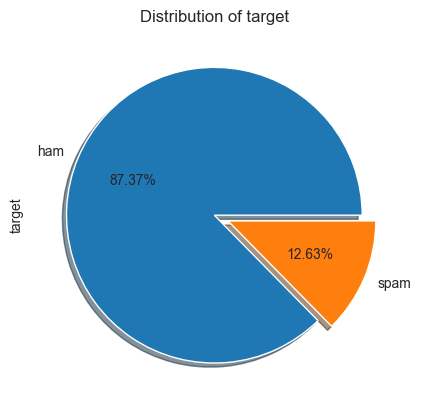

In [84]:
email_data['target'].value_counts().plot(kind='pie', autopct='%.2f%%', shadow=True, explode=[0,0.1])
plt.title("Distribution of target")
plt.show()

##### Data is imbalanced. So, we have to deal it carefully.

In [85]:
email_data

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [86]:
# Count number of characters
email_data['num_characters'] = email_data['text'].apply(len)

C:\Users\user\AppData\Local\Temp\ipykernel_6636\3065275208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_data['num_characters'] = email_data['text'].apply(len)


In [87]:
# Count number of words
email_data['num_words'] = email_data['text'].apply(lambda x: len(nltk.word_tokenize(x)))

C:\Users\user\AppData\Local\Temp\ipykernel_6636\1631162375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_data['num_words'] = email_data['text'].apply(lambda x: len(nltk.word_tokenize(x)))


In [88]:
email_data.head()

,target,text,num_characters,num_words
0,ham,"Go until jurong point, crazy.. Available only ...",111,24
1,ham,Ok lar... Joking wif u oni...,29,8
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,ham,U dun say so early hor... U c already then say...,49,13
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15


In [89]:
# Count number of sentences
email_data['num_sentences'] = email_data['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

C:\Users\user\AppData\Local\Temp\ipykernel_6636\4092366410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_data['num_sentences'] = email_data['text'].apply(lambda x: len(nltk.sent_tokenize(x)))


In [90]:
email_data.head()

,target,text,num_characters,num_words,num_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [91]:
email_data.describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [92]:
# ham text
email_data[email_data['target']=='ham'][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [93]:
# spam text
email_data[email_data['target']=='spam'][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


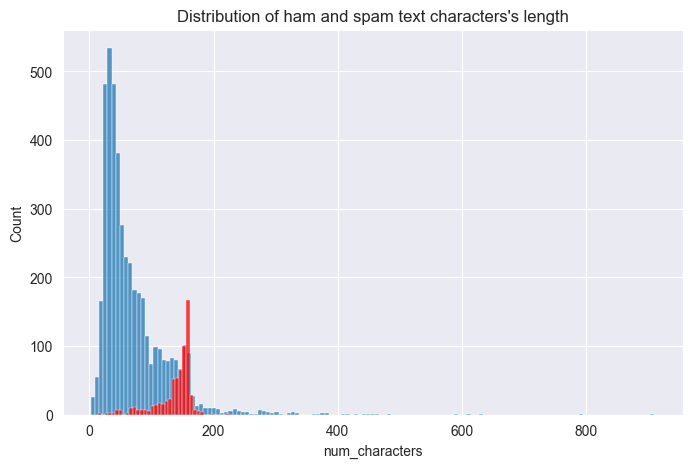

In [94]:
# Histogram for 'ham' and 'spam' text
plt.figure(figsize=(8,5))
sns.histplot(email_data[email_data['target']=='ham']['num_characters'])
sns.histplot(email_data[email_data['target']=='spam']['num_characters'], color='red')
plt.title("Distribution of ham and spam text characters's length")
plt.show()

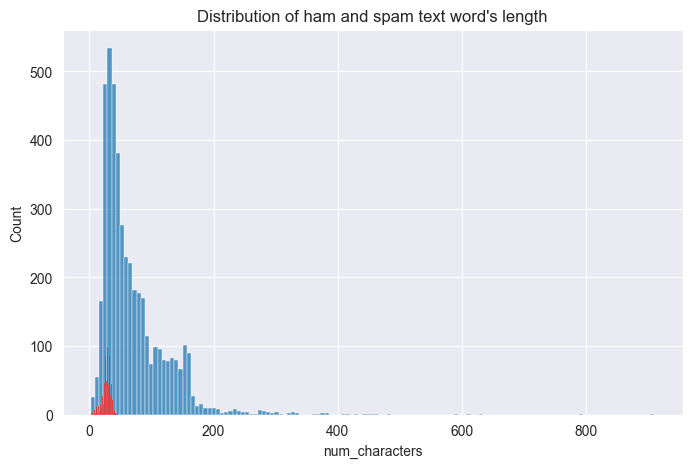

In [95]:
# Histogram for 'ham' and 'spam' text
plt.figure(figsize=(8,5))
sns.histplot(email_data[email_data['target']=='ham']['num_characters'])
sns.histplot(email_data[email_data['target']=='spam']['num_words'], color='red')
plt.title("Distribution of ham and spam text word's length")
plt.show()

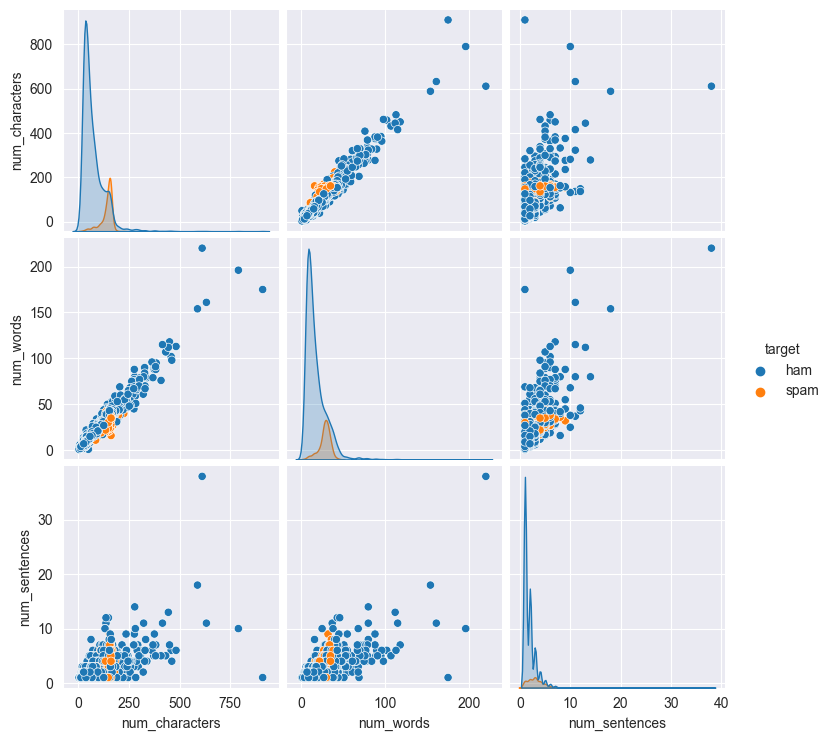

In [96]:
sns.pairplot(email_data, hue='target')
plt.show()

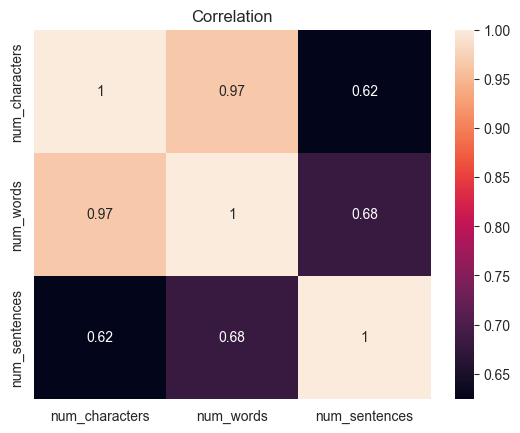

In [97]:
corr = email_data.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title("Correlation")
plt.show()

##### As can be seen, the mean characters, mean number and mean sentences of spam text is larger than ham text. So,we can say that normally spam text are longer than non spam.

### Data Preprocessing

In [98]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [99]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [100]:
ps = PorterStemmer()

In [101]:
# Function for text-preprocessing
def transform_text(text):
    text = text.lower()   # Lower-case
    text = nltk.word_tokenize(text)   # Tokenize the text on  word level
    
    y = []
    for i in text:
        if i.isalnum():    # Check whether the text is either alpha or numeric
            y.append(i)    # If yes, append otherwise, remove special characters
            
    text = y[:]
    y.clear()
    
    for j in text:    # Removing stopwords
        if j not in stopwords.words('english') and j not in string.punctuation:
            y.append(j)
            
    text = y[:]
    y.clear()
    
    for k in  text:
        y.append(ps.stem(k))    # Convert the word to root form
    
    return " ".join(y)

In [102]:
email_data['transformed_text'] = email_data['text'].apply(transform_text)

C:\Users\user\AppData\Local\Temp\ipykernel_6636\1671709567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_data['transformed_text'] = email_data['text'].apply(transform_text)


In [103]:
email_data.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [104]:
# WordCloud
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

In [105]:
spam_wordcloud = wc.generate(email_data[email_data['target']=='spam']['transformed_text'].str.cat(sep=""))

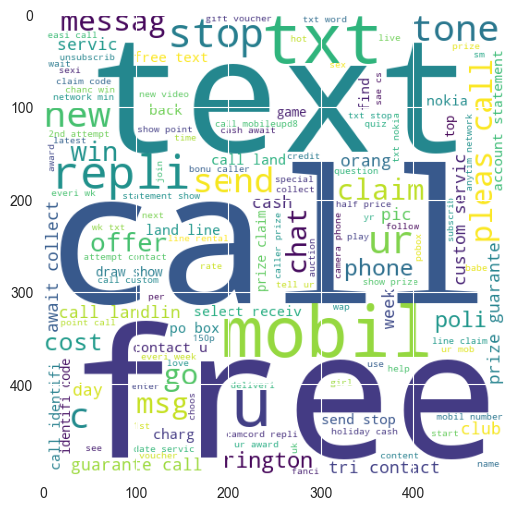

In [106]:
# Spam words
plt.figure(figsize=(8,6))
plt.imshow(spam_wordcloud)
plt.show()

In [107]:
ham_wordcloud = wc.generate(email_data[email_data['target']=='ham']['transformed_text'].str.cat(sep=""))

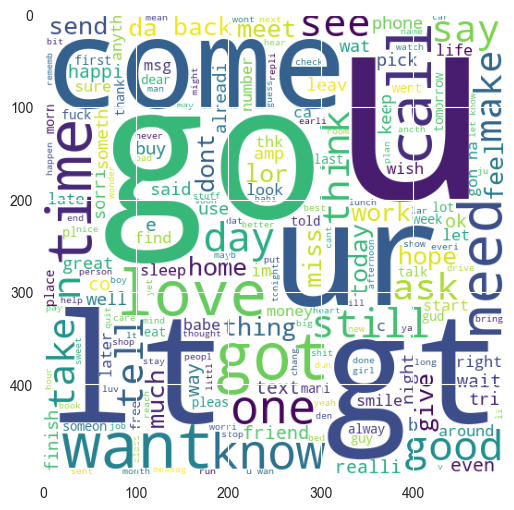

In [108]:
# Ham words
plt.figure(figsize=(8,6))
plt.imshow(ham_wordcloud)
plt.show()

In [109]:
email_data.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [110]:
spam_corpus = []
for msg in email_data[email_data['target']=='spam']['transformed_text'].tolist():
    
    for word in msg.split():
        spam_corpus.append(word)
    

In [111]:
len(spam_corpus)

9939

In [112]:
# Top 30 words in spam text
spam_common_words = pd.DataFrame(Counter(spam_corpus).most_common(30))
spam_common_words.head()

,0,1
0,call,320
1,free,191
2,2,155
3,txt,141
4,text,122


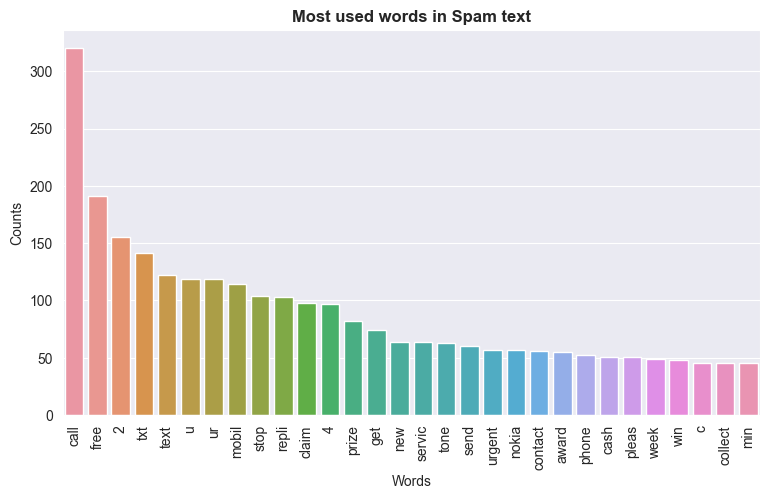

In [113]:
plt.figure(figsize=(9,5))
sns.barplot(x=spam_common_words[0], y=spam_common_words[1])
plt.xticks(rotation=90)
plt.title("Most used words in Spam text", fontweight='bold')
plt.xlabel("Words")
plt.ylabel("Counts")
plt.show()

In [114]:
ham_corpus = []
for msg in email_data[email_data['target']=='ham']['transformed_text'].tolist():
    
    for word in msg.split():
        ham_corpus.append(word)

In [115]:
len(ham_corpus)

35404

In [116]:
# Top 30 words in ham text
ham_common_words = pd.DataFrame(Counter(ham_corpus).most_common(30))
ham_common_words.head()

,0,1
0,u,883
1,go,404
2,get,349
3,gt,288
4,lt,287


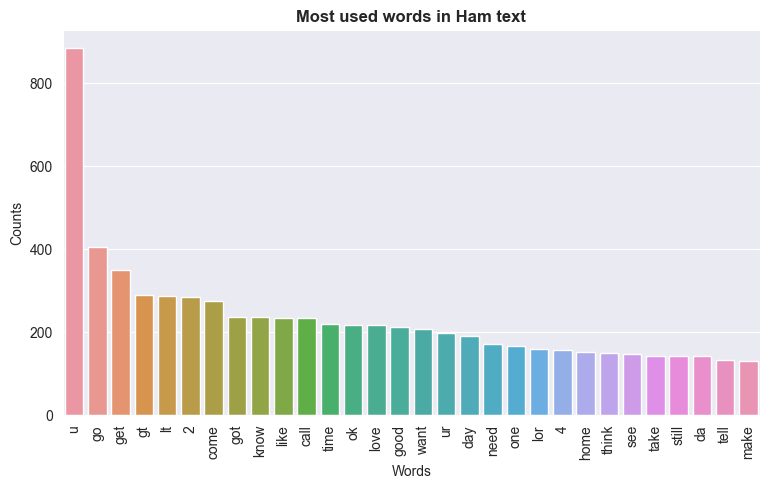

In [117]:
plt.figure(figsize=(9,5))
sns.barplot(x=ham_common_words[0], y=ham_common_words[1])
plt.xticks(rotation=90)
plt.xlabel("Words")
plt.ylabel('Counts')
plt.title("Most used words in Ham text", fontweight='bold')
plt.show()

In [118]:
email_data.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


#### Vectorization

In [119]:
# Encode target feature
email_data['target'] = email_data['target'].map({'ham': 0, 'spam':1})
email_data['target'].head()

C:\Users\user\AppData\Local\Temp\ipykernel_6636\3449738616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_data['target'] = email_data['target'].map({'ham': 0, 'spam':1})


0    0
1    0
2    1
3    0
4    0
Name: target, dtype: int64

In [120]:
y = email_data['target'].values
y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [142]:
# CountVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

##### We can choose either CountVectorizer or TfidfVectorizer depending upon performance.

In [141]:
X = tfidf.fit_transform(email_data['transformed_text']).toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [143]:
# Data partioning
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=23)

### Model Training

#### Gaussian Naive Bayes

In [137]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [138]:
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.8713733075435203
[[801 115]
 [ 18 100]]
0.46511627906976744


In [139]:
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.9816247582205029
[[916   0]
 [ 19  99]]
1.0


In [140]:
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.9874274661508704
[[915   1]
 [ 12 106]]
0.9906542056074766


##### We have used Tfidf as vectorizer and multinomial naive bayes as model

#### Pickling the model

In [144]:
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))